# Estimating COVID-19's $R_t$ for x nations

Walter Rafelsberger - May 02

This notebook is an adaptation of [Kevin Systrom's notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20Rt%20mcmc.ipynb) to calculate $R_t$, however, instead of US states this does the calculation for worldwide nations.

## Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [111]:
# setup conda environment
# https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

# how to add a conda environment to jupyter notebooks
# https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084

# check if python executable matches environment
import sys
print(sys.executable)

/usr/local/anaconda3/envs/covid-19/bin/python


In [112]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [113]:
file = '../data/covid19-feature.csv'
states_AT = pd.read_csv(file)
states_AT['date'] = pd.to_datetime(states_AT['date'], format='%Y-%m-%d')
states_AT.head()

,date,location,total_cases,days_since_first,days_since_tenth,days_since_hundreth,life_expectancy,dalys,population,age_young,age_working,age_eldery,mobility,population_density
0,2019-12-31,Afghanistan,0,0,0,0,65,56925,38042000,15023530,17871866,841098,-9.0,54
1,2020-01-01,Afghanistan,0,0,0,0,65,56925,38042000,15023530,17871866,841098,-9.0,54
2,2020-01-02,Afghanistan,0,0,0,0,65,56925,38042000,15023530,17871866,841098,-9.0,54
3,2020-01-03,Afghanistan,0,0,0,0,65,56925,38042000,15023530,17871866,841098,-9.0,54
4,2020-01-04,Afghanistan,0,0,0,0,65,56925,38042000,15023530,17871866,841098,-9.0,54


In [114]:
# date, state, positive
states_AT_melt = states_AT[['date', 'location', 'total_cases']]
states_AT_melt.columns = ['date', 'state', 'positive']
states_AT_melt.head()

,date,state,positive
0,2019-12-31,Afghanistan,0
1,2020-01-01,Afghanistan,0
2,2020-01-02,Afghanistan,0
3,2020-01-03,Afghanistan,0
4,2020-01-04,Afghanistan,0


#### Clean data with known modifications

In [145]:
# Errors in Covidtracking.com
states_AT_melt_i = states_AT_melt.set_index(['state', 'date'])

states_AT_melt_i.loc[('Spain','2020-04-19'), 'positive'] = 190585
# states_AT_melt_i.loc[('Thailand','2020-03-04'), 'positive'] = 1
# states_AT_melt_i.loc[('Thailand','2020-03-06'), 'positive'] = 1
# states_AT_melt_i.loc[('Thailand','2020-03-08'), 'positive'] = 1
# states_AT_melt_i.loc[('Thailand','2020-03-09'), 'positive'] = 1
# states_AT_melt_i.loc[('Thailand','2020-03-10'), 'positive'] = 1
# states_AT_melt_i.loc[('Thailand','2020-03-13'), 'positive'] = 1

states_AT_melt_i.head()

positive
state       date                
Afghanistan 2019-12-31         0
            2020-01-01         0
            2020-01-02         0
            2020-01-03         0
            2020-01-04         0

#### Integrity Check

In [146]:
# Make sure that all the states have current data
states = states_AT_melt_i
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
Afghanistan           2020-05-02
Angola                2020-05-02
Antigua and Barbuda   2020-05-02
Argentina             2020-05-02
Australia             2020-05-02
                         ...    
Venezuela             2020-05-02
Vietnam               2020-05-02
Yemen                 2020-05-02
Zambia                2020-05-02
Zimbabwe              2020-05-02
Name: date, Length: 121, dtype: datetime64[ns]

state       date      
Bangladesh  2020-03-10   -3.0
            2020-03-16   -3.0
Name: positive, dtype: float64

state    date      
Belarus  2020-03-03   -1.0
Name: positive, dtype: float64

state     date      
Colombia  2020-03-08   -1.0
          2020-03-11   -3.0
          2020-03-13   -9.0
Name: positive, dtype: float64

state    date      
Croatia  2020-03-05    -9.0
         2020-03-09   -12.0
Name: positive, dtype: float64

state    date      
Estonia  2020-03-03    -1.0
         2020-03-05    -2.0
         2020-03-08   -10.0
Name: positive, dtype: float64

state    date      
Finland  2020-03-03    -6.0
         2020-03-05    -7.0
         2020-03-08   -19.0
         2020-03-11   -40.0
Name: positive, dtype: float64

state   date      
Greece  2020-03-03   -7.0
Name: positive, dtype: float64

state    date      
Hungary  2020-03-06   -2.0
Name: positive, dtype: float64

state   date      
Israel  2020-03-03   -10.0
        2020-03-10   -39.0
Name: positive, dtype: float64

state   date      
Latvia  2020-03-04   -1.0
Name: positive, dtype: float64

state      date      
Lithuania  2020-03-04     -1.0
           2020-03-13     -3.0
           2020-04-29   -105.0
Name: positive, dtype: float64

state   date      
Mexico  2020-03-03   -5.0
        2020-03-10   -7.0
Name: positive, dtype: float64

state  date      
Nepal  2020-03-03   -1.0
       2020-03-16   -1.0
Name: positive, dtype: float64

state        date      
New Zealand  2020-03-09   -5.0
             2020-03-16   -8.0
Name: positive, dtype: float64

state     date      
Paraguay  2020-03-10   -1.0
          2020-03-12   -5.0
          2020-03-15   -7.0
Name: positive, dtype: float64

state  date      
Peru   2020-03-08   -1.0
Name: positive, dtype: float64

state   date      
Poland  2020-03-05   -1.0
Name: positive, dtype: float64

state    date      
Senegal  2020-03-04   -1.0
         2020-03-07   -4.0
Name: positive, dtype: float64

state         date      
South Africa  2020-03-07   -1.0
              2020-03-11   -7.0
Name: positive, dtype: float64

state     date      
Thailand  2020-03-03   -43.0
          2020-03-06   -47.0
          2020-03-08   -50.0
          2020-03-13   -70.0
Name: positive, dtype: float64

state    date      
Vietnam  2020-03-03   -16.0
Name: positive, dtype: float64

UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [1], lexsort depth 0'

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [119]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [120]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

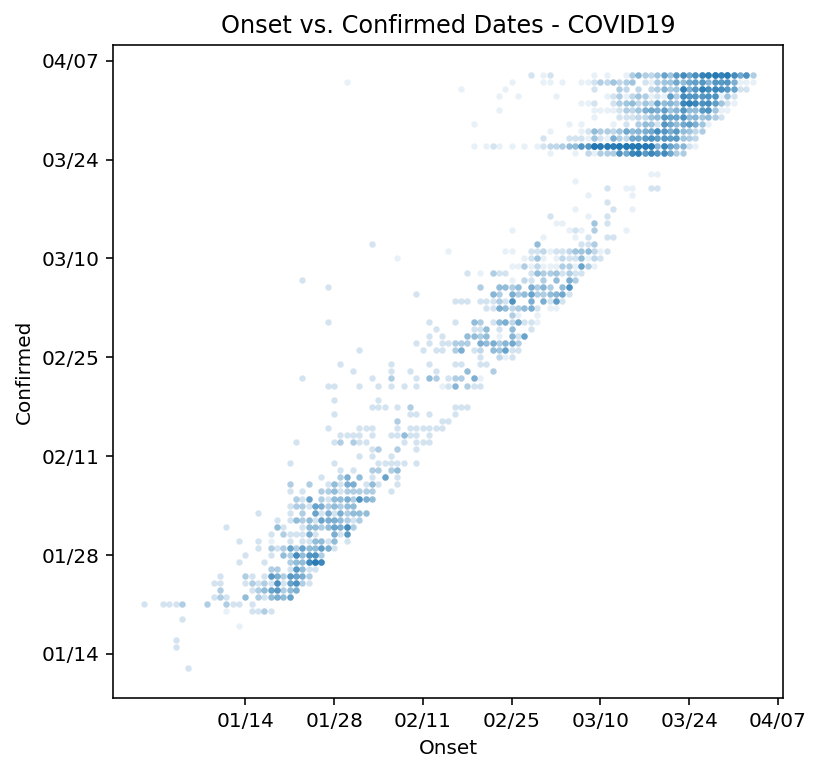

In [121]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

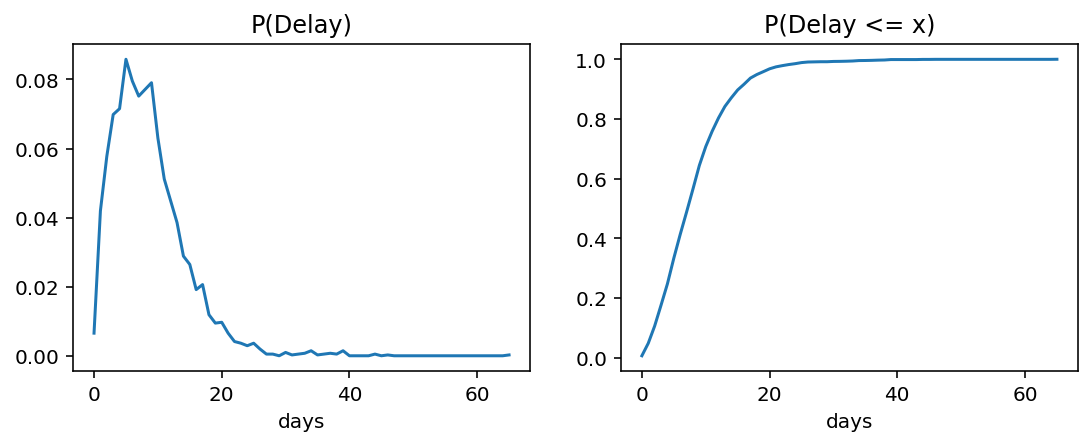

In [122]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [152]:
state = 'Sweden'
confirmed = states.xs(state).positive.diff().dropna()
confirmed.tail()

date
2020-04-28    286.0
2020-04-29    695.0
2020-04-30    681.0
2020-05-01    790.0
2020-05-02    428.0
Name: positive, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [153]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [154]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

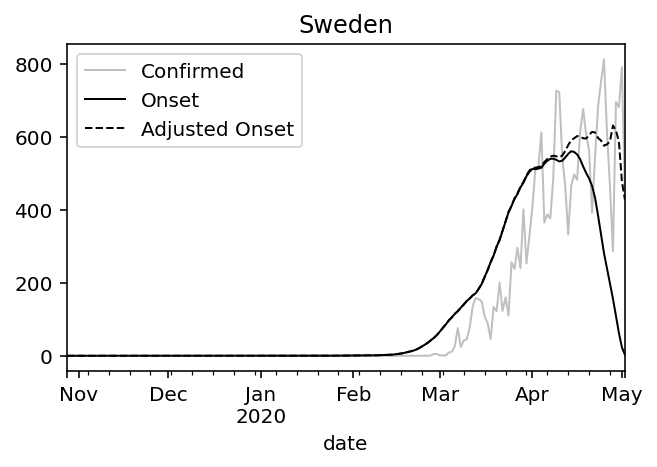

In [155]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 60 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [156]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=90):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [157]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [166]:
# df.loc[~df.index.str.endswith('_test')]
states_model = states.iloc[states.index.get_level_values('state').isin([
    'United States',
    'Spain',
    'Italy',
    'United Kingdom',
    'France',
    'Germany',
    'Turkey',
    'Russia',
    'Brazil',
    'Iran',
    'China',
    'Canada',
    'Belgium',
    'Peru',
    'Netherlands',
    'India',
    'Switzerland',
    'Ecuador',
    'Saudi Arabia',
    'Portugal',
    'Sweden',
    'Ireland',
    'Mexico',
    'Pakistan',
    'Chile',
    'Singapore',
    'Israel',
    'Belarus',
    'Austria',
    'Qatar',
    'Japan',
    'South Korea',
    'Norway'
])]
states_model.head()

positive
state   date                
Austria 2019-12-31         0
        2020-01-01         0
        2020-01-02         0
        2020-01-03         0
        2020-01-04         0

In [167]:
models = {}

for state, grp in states_model.groupby('state'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_run_model(state, grp.droplevel(0))

Austria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:47<00:00, 83.75it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Belarus


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:35<00:00, 111.90it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Belgium


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:57<00:00, 70.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Brazil


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:59<00:00, 66.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Canada


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:58<00:00, 68.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Chile


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:33<00:00, 119.01it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ecuador


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:38<00:00, 18.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


France


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:05<00:00, 60.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Germany


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:41<00:00, 39.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


India


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:39<00:00, 102.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ireland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:41<00:00, 95.80it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Israel


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 104.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Italy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:04<00:00, 62.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Japan


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:33<00:00, 119.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Mexico


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 10 divergences: 100%|██████████| 4000/4000 [00:31<00:00, 128.17it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Netherlands


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:51<00:00, 78.22it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Norway


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:28<00:00, 138.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Pakistan


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 2 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 131.34it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Peru


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:52<00:00, 76.25it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Portugal


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:47<00:00, 85.06it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Qatar


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 131.45it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Saudi Arabia


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:32<00:00, 122.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Singapore


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:43<00:00, 91.70it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


South Korea


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 132.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Spain


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:40<00:00, 39.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sweden


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:30<00:00, 132.18it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Switzerland


INFO (theano.gof.compilelock): Refreshing lock /Users/walterra/.theano/compiledir_Darwin-19.3.0-x86_64-i386-64bit-i386-3.6.10-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:51<00:00, 78.15it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


Turkey


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:10<00:00, 57.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


United Kingdom


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:03<00:00, 62.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


United States


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:11<00:00, 20.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [168]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


Belarus      1
Mexico      10
Pakistan     2
Qatar        1
Sweden       1
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:36<00:00, 111.05it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:34<00:00, 116.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 diverge

## Compile Results

In [169]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

### Render to CSV
Uncomment if you'd like

In [170]:
results.to_csv('../data/world_rt.csv')

### Render Charts

In [171]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0, 2)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

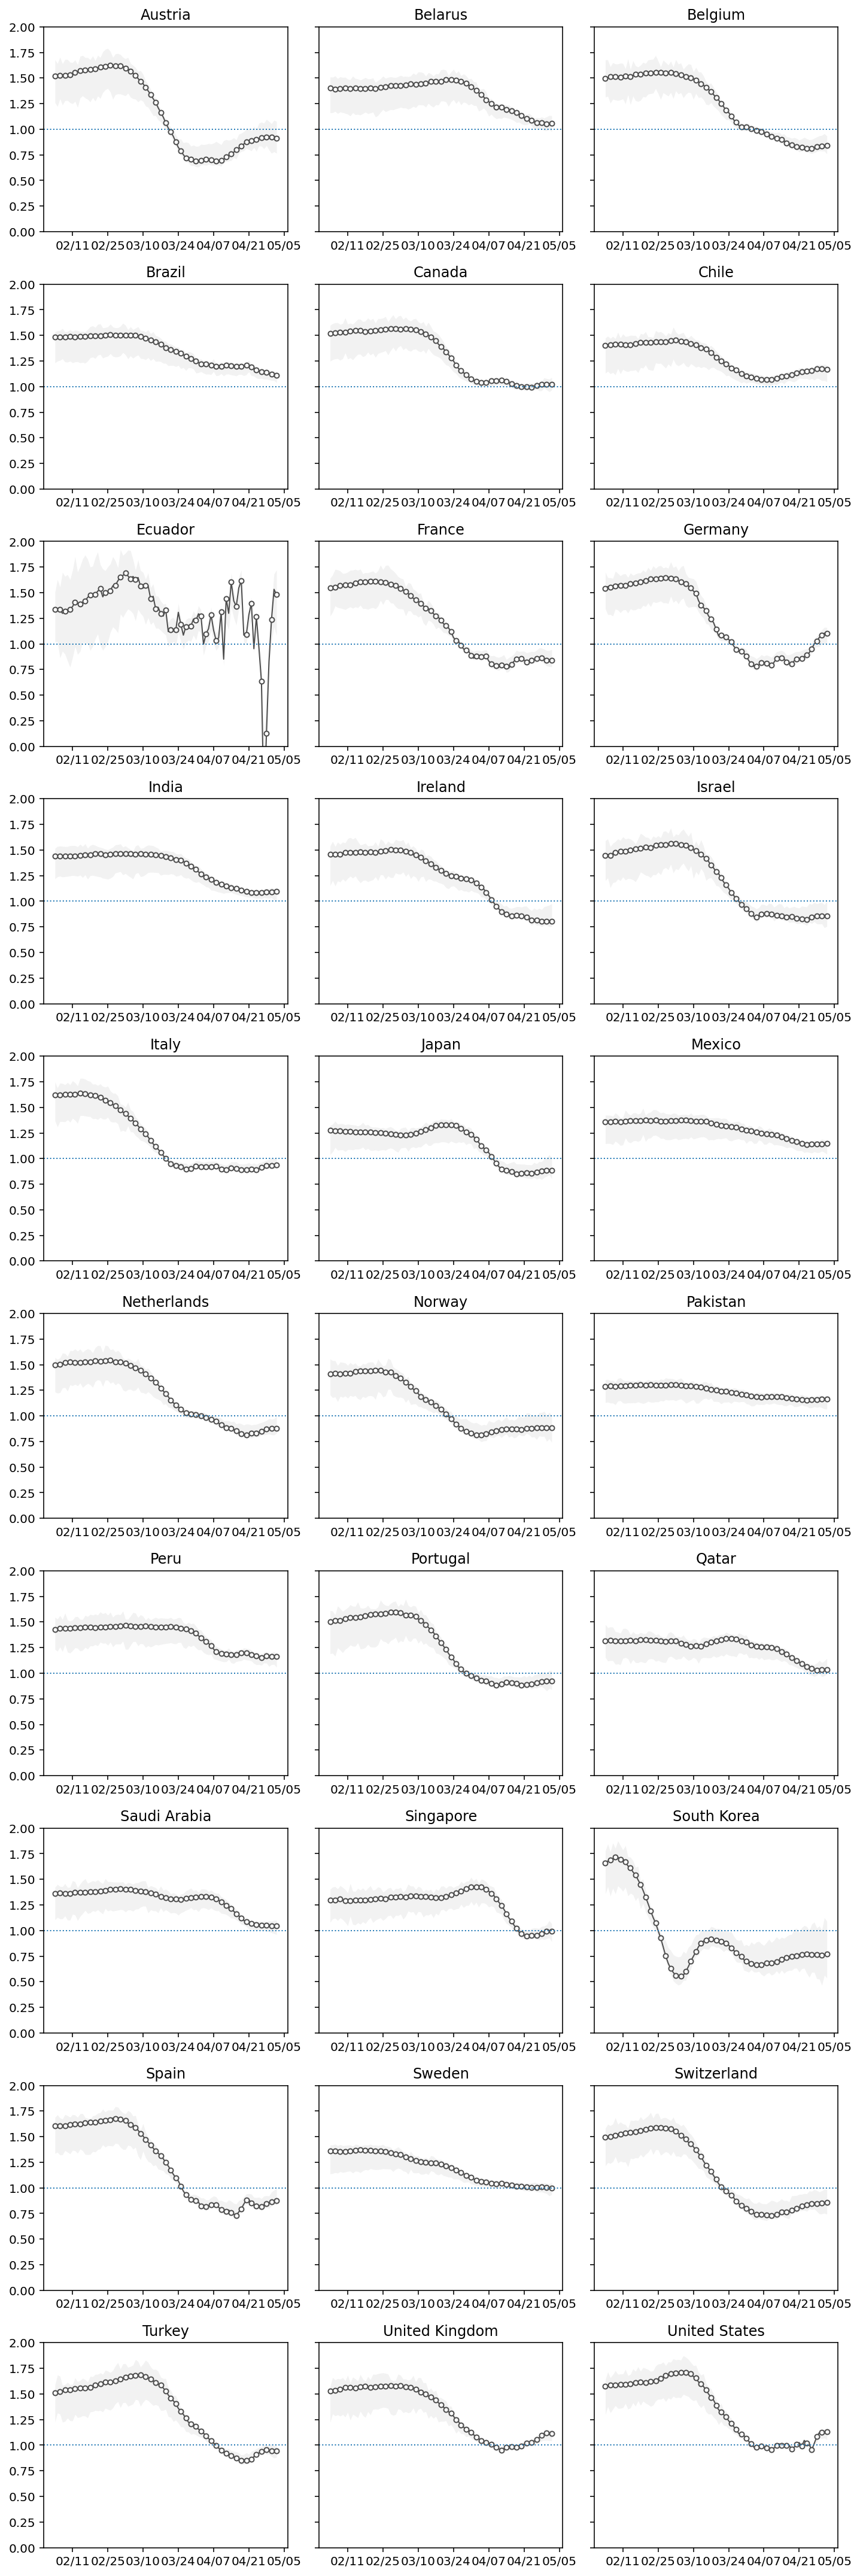

In [172]:
ncols = 3
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(10, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')